In [1]:
import bopt
import tqdm
import torch
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

##### save images and set to use the libertine font (required for ACM)

In [2]:
save_images = False

In [3]:
if save_images:
    # configure matplotlib to use latex so we're able to use the libertine font
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}',
                                           r'\usepackage[libertine]{newtxmath}',
                                           r'\usepackage{sfmath}',
                                           r'\usepackage[T1]{fontenc}'
                                          ]
    
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['backend'] = 'pdf'
    
else:
    plt.rcParams['text.usetex'] = False

# Load all optimisation runs

In [4]:
start_run = 1
end_run = 51
problems = [('Branin', {}),
            ('Eggholder', {}),
            ('GoldsteinPrice', {}),
            ('SixHumpCamel',{} ),
            ('Shekel', {}),
            ('Ackley', {'d': 5}),
            ('Hartmann6', {}),
            ('Michalewicz', {'d': 10}),
            ('Rosenbrock', {'d': 10}),
            ('StyblinskiTang', {'d': 10}),
            ('push4', {}),
            ('push8', {}),
            ('PitzDaily', {})
            ]

budget = 200

mean_names = ['MeanZero',
              'MeanMedian',
              'MeanMin',
              'MeanMax',
              'MeanLinearCV',
              'MeanQuadraticCV',
              'MeanRandomForrest',
              'MeanRBFCV',
              ]

acq_names = ['EI', 'UCB']

tablau20 = np.array([
    [ 31, 119, 180], [255, 127,  14], [ 44, 160,  44], [214,  39,  40],
    [148, 103, 189], [140,  86,  75], [227, 119, 194], [127, 127, 127],
    [188, 189,  34], [ 23, 190, 207], [174, 199, 232], [255, 187, 120],
    [152, 223, 138], [255, 152, 150], [197, 176, 213], [196, 156, 148],
    [247, 182, 210], [199, 199, 199], [219, 219, 141], [158, 218, 229]
]) / 255.

mean_cols = tablau20[:len(mean_names)]

total = len(acq_names) * len(problems) * len(mean_names) * (end_run - start_run + 1)

# D[acq_name][MeanName]
D = {}

with tqdm.notebook.tqdm(total=total, leave=True) as pbar:
    for acq_name in acq_names:
        D[acq_name] = {}

        for problem_name, problem_params in problems:
            D[acq_name][problem_name] = {}

            f_class = getattr(bopt.test_problems, problem_name)
            f = f_class(**problem_params)
            
            for mean_name in mean_names:
                res = np.zeros((end_run - start_run + 1, budget))

                for i, run_no in enumerate(range(start_run, end_run + 1)):
                    fn = bopt.util.generate_save_filename(problem_name, mean_name, 
                                                          acq_name, run_no, 
                                                          problem_params=problem_params)
                    try:
                        data = torch.load(fn)
                        Ytr = data['Ytr'].numpy().ravel()
                        n = Ytr.size
                        
                        res[i, :n] = Ytr
                        if n != budget:
                            print('Not full:', fn, Ytr.shape)

                    except FileNotFoundError:
                        print('Missing', fn)
                    except:
                        print(fn)
                        raise
                    
                    pbar.update()

                res = np.abs(res - f.yopt.ravel()[0])
                D[acq_name][problem_name][mean_name] = np.minimum.accumulate(res, axis=1)

In [5]:
def results_plot_maker(ax, yvals, xvals, xlabel, ylabel, title, colors,
                       LABEL_FONTSIZE, TITLE_FONTSIZE, TICK_FONTSIZE,
                       use_fill_between=True,
                       fix_ticklabels=False):
    # here we assume we're plotting to a matplotlib axis object
    # and yvals is a LIST of arrays of size (n_runs, iterations),
    # where each can be different sized
    # and if xvals is given then len(xvals) == len(yvals)

    # set the labelling
    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)

    for color, x, Y in zip(colors, xvals, yvals):
        bot, mid, top = [_.ravel() for _ in 
                         np.percentile(Y, [25, 50, 75], axis=0)]

        if use_fill_between:
            ax.fill_between(x, bot.flat, top.flat, color=color, alpha=0.15)

        ax.plot(x, mid, color=color)
        ax.plot(x, bot, '--', color=color, alpha=0.15)
        ax.plot(x, top, '--', color=color, alpha=0.15)

    # set the xlim
    min_x = np.min([np.min(x) for x in xvals])
    max_x = np.max([np.max(x) for x in xvals])
    ax.set_xlim([0, max_x + 1])

    ax.axvline(min_x, linestyle='dashed', color='gray', linewidth=1, alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)
    
    # set the alignment for outer ticklabels
    ax.set_xticks([0, 50, 100, 150, 200])
    if fix_ticklabels:
        ticklabels = ax.get_xticklabels()
        if len(ticklabels) > 0:
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

# Combined plots for each acquisition function

In [6]:
# y-axis bounds for each problem
bounds_dict = {'Branin': [-5.8, 1.5],
               'Eggholder': [-0.3, 2.7],
               'GoldsteinPrice': [-2, 3.1],
               'SixHumpCamel': [-5.8, 0.4],
               'Shekel': [-4.5, 1.1],
               'Ackley': [-0.25, 1.35],
               'Hartmann6': [-3.7, 0.5],
               'Michalewicz': [-2.4, 0.45],
               'Rosenbrock': [2.6, 5.5],
               'StyblinskiTang': [1.4, 2.35],
               'push4': [-1.7, 0.5],
               'push8': [0.10, 1.0],
               'PitzDaily': [0.083, 0.12],
               }

LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 20
TICK_FONTSIZE = 15

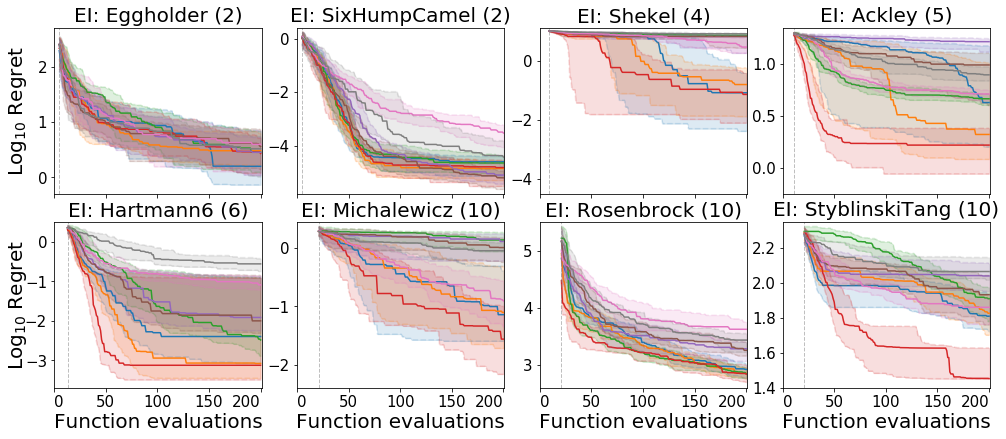

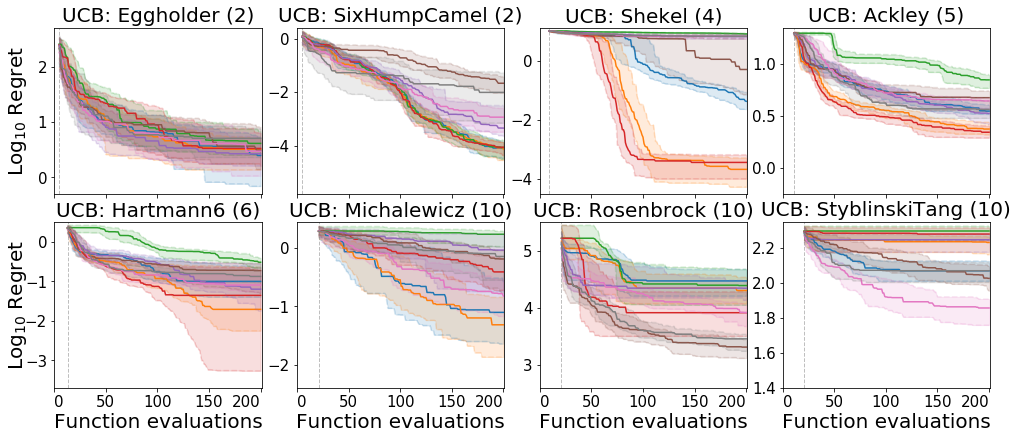

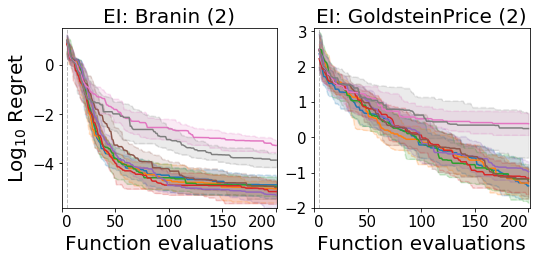

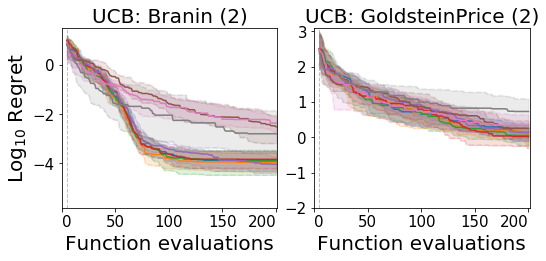

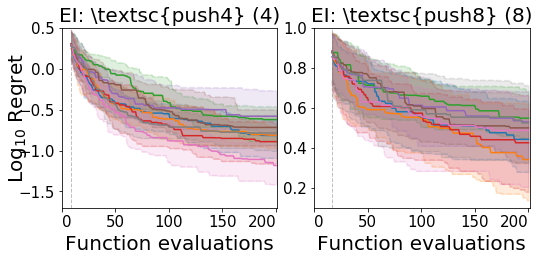

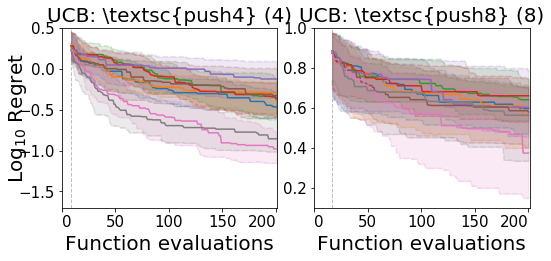

In [7]:
problem_sets = [
                [[('Eggholder', {}),
                 ('SixHumpCamel',{}),
                 ('Shekel', {}),
                 ('Ackley', {'d': 5}),
                ],
                 
                [('Hartmann6', {}),
                 ('Michalewicz', {'d': 10}),
                 ('Rosenbrock', {'d': 10}),
                 ('StyblinskiTang', {'d': 10})
                ]],
    
                [[('Branin', {}),
                  ('GoldsteinPrice', {}),
                ]],

                [[('push4', {}),
                  ('push8', {}),
                ]],
]

fnames = ['synthetic', 'supp', 'push']

for problem_rows, fname in zip(problem_sets, fnames):
    for acq_name in acq_names:
        nrows = len(problem_rows)
        ncols =  len(problem_rows[0])

        w = 13/4
        h = 5/2

        fig, a = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), 
                              sharex=True, sharey=False)

        for i, problem_row in enumerate(problem_rows):
            for j, (problem_name, problem_params) in enumerate(problem_row):
                try:
                    ax = a[i, j]
                except IndexError:
                    ax = a[j]
                except TypeError:
                    ax = a

                f_class = getattr(bopt.test_problems, problem_name)
                f = f_class(**problem_params)

                N = res.shape[1]

                start = 2 * f.dim
                end = N

                x = np.arange(start + 1, end + 1)
                xmin = start + 1
                xmax = end + 1

                yvals = []
                xvals = []

                for mean_name in mean_names:
                    Y = D[acq_name][problem_name][mean_name][:, start:end]

                    if problem_name != 'PitzDaily':
                        Y = np.log10(Y)

                    yvals.append(Y)
                    xvals.append(x)

                if problem_name == 'push4':
                    pn = r'\textsc{push4}'
                elif problem_name == 'push8':
                    pn = r'\textsc{push8}'
                else:
                    pn = problem_name
                
                title = f'{acq_name}: {pn:s} ({f.dim:d})'

                if j == 0:
                    if problem_name != 'push8':
                        ylabel = 'Log$_{10}$ Regret'
                else:
                    ylabel = None

                if i == len(problem_rows)-1:
                    xlabel = 'Function evaluations'
                else:
                    xlabel = None

                results_plot_maker(ax, yvals, xvals, xlabel, ylabel, 
                                   title, mean_cols, 
                                   LABEL_FONTSIZE, 
                                   TITLE_FONTSIZE, 
                                   TICK_FONTSIZE,
                                   use_fill_between=True,
                                   fix_ticklabels=True)

                # ensure labels are all in the same place!
                if ncols == 4:
                    ax.get_yaxis().set_label_coords(-0.12, 0.5)
                elif ncols == 2:
                    ax.get_yaxis().set_label_coords(-0.15, 0.5)
                    
                ax.get_xaxis().set_label_coords(0.5, -0.15)
                    
                if bounds_dict[problem_name] is not None:
                    ax.set_ylim(bounds_dict[problem_name])
                

        plt.subplots_adjust(left=0,
                        right=1,
                        bottom=0,
                        top=1,
                        wspace=0.17,
                        hspace=0.17)


        if save_images:
            fnamesave = f'convergence_{fname}_{acq_name:s}.pdf'
            plt.savefig(fnamesave, bbox_inches='tight')
        plt.show()

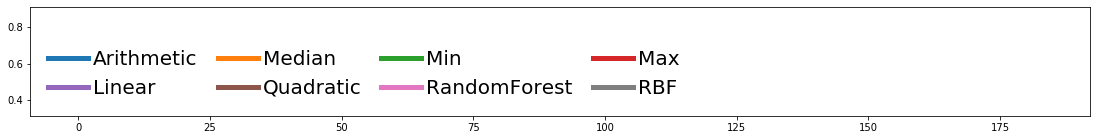

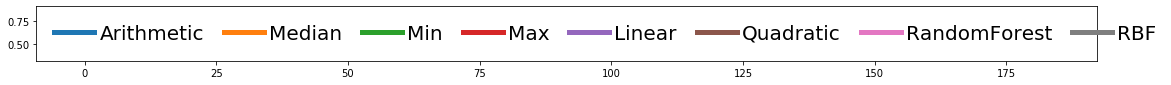

In [8]:
for namecols, ncols in [('onecol', 4), ('twocol',8)]:
    problem_name == problems[0][0]
    if ncols == 4:
        h = 2
    else:
        h = 1
    fig, ax = plt.subplots(1, 1, figsize=(19, h), sharey=False)
    for mean_name, color in zip(mean_names, mean_cols):
        Y = np.log10(D['EI'][problem_name][mean_name][:, 2 * f.dim:])
        bot, mid, top = np.percentile(Y, [25, 50, 75], axis=0)
            
        if mean_name == 'MeanZero':
            mean_name = 'MeanArithmetic'
        
        if 'CV' in mean_name:
            mean_name = mean_name.replace('CV', '')
            
        if 'Forrest' in mean_name:
            mean_name = mean_name.replace('Forrest', 'Forest')
        
        ax.plot(mid, color=color, label=mean_name[4:])


    legend_options = {'loc': 3, 
                      'framealpha': 1, 
                      'frameon': False,
                      'fontsize': 20,
                      'handletextpad': 0.25,
                      'columnspacing': 1,
                      'ncol': ncols}
        
    legend = ax.legend(**legend_options)
    
    if ncols == 4:
        inds = [0, 4, 1, 5, 2, 6, 3, 7]
    else:
        inds = [0, 1, 2, 3, 4, 5, 6, 7]

    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[i] for i in inds]
    labels = [labels[i] for i in inds]
    legend = ax.legend(handles, labels, **legend_options)
    
    # increase legend line widths
    for legobj in legend.legendHandles:
        legobj.set_linewidth(5.0)

    # remove all plotted lines
    for _ in range(len(ax.lines)):
        ax.lines.pop(0)

    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*[bbox.extents + np.array([-5, -5, 5, 5])])
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

    if save_images:
        fname = f'legend_{namecols}.pdf'
        fig.savefig(fname, dpi='figure', bbox_inches=bbox)  

    plt.show()

# special plot for PitzDaily

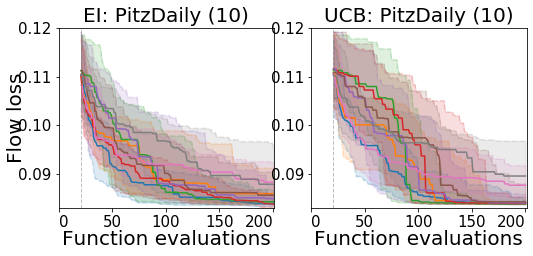

In [9]:
w = 13/4
h = 5/2

fig, a = plt.subplots(1, 2, figsize=(w*2, h*1), 
                      sharex=True, sharey=False)

problem_name = 'PitzDaily'
problem_params = {}

for ax, acq_name in zip(a, acq_names):
    f_class = getattr(bopt.test_problems, problem_name)
    f = f_class(**problem_params)

    N = res.shape[1]

    start = 2 * f.dim
    end = N

    x = np.arange(start + 1, end + 1)
    xmin = start + 1
    xmax = end + 1

    yvals = []
    xvals = []

    for mean_name in mean_names:
        Y = D[acq_name][problem_name][mean_name][:, start:end]
        yvals.append(Y)
        xvals.append(x)

    title = f'{acq_name}: {problem_name:s} ({f.dim:d})'

    if ax == a[0]:
        ylabel = 'Flow loss'
    else:
        ylabel = None

    xlabel = 'Function evaluations'
    
    results_plot_maker(ax, yvals, xvals, xlabel, ylabel, 
                       title, mean_cols, 
                       LABEL_FONTSIZE, 
                       TITLE_FONTSIZE, 
                       TICK_FONTSIZE,
                       use_fill_between=True,
                       fix_ticklabels=True)

    # ensure labels are all in the same place!
    ax.get_yaxis().set_label_coords(-0.15, 0.5)
    ax.get_xaxis().set_label_coords(0.5, -0.12)
    if bounds_dict[problem_name] is not None:
        ax.set_ylim(bounds_dict[problem_name])

plt.subplots_adjust(left=0,
                right=1,
                bottom=0,
                top=1,
                wspace=0.17,
                hspace=0.17)


if save_images:
    fnamesave = f'convergence_PitzDaily_EIUCB.pdf'
    plt.savefig(fnamesave, bbox_inches='tight')
plt.show()

# latex table creation

In [10]:
from scipy.stats import median_absolute_deviation, wilcoxon
from statsmodels.stats.multitest import multipletests

def create_table_data(results, acq_names, problem_names, mean_names, n_exps, time=-1):
    """

    """
    mean_names = np.array(mean_names)
    n_means = len(mean_names)

    # table_data[problem_name] = {'median', 'MAD', 'stats_equal_to_best_mask'}
    table_data = {}

    for acq_name in acq_names:
        table_data[acq_name] = {}
        
        for problem_name, _ in problem_names:
            best_seen_values = np.zeros((n_means, n_exps))

            for i, mean_name in enumerate(mean_names):
                # best seen evaluate at the end of the optimisation run
                best_seen_values[i, :] = results[acq_name][problem_name][mean_name][:, time]

            medians = np.median(best_seen_values, axis=1)
            MADS = median_absolute_deviation(best_seen_values, axis=1)

            # best method -> lowest median value
            best_method_idx = np.argmin(medians)

            # mask of methods equivlent to the best
            stats_equal_to_best_mask = np.zeros(n_means, dtype='bool')
            stats_equal_to_best_mask[best_method_idx] = True

            # perform wilcoxon signed rank test between best and all other methods
            p_values = []
            for i, mean_name in enumerate(mean_names):
                if i == best_method_idx:
                    continue
                # a ValueError will be thrown if the runs are all identical,
                # therefore we can assign a p-value of 0 as they are identical
                try:
                    _, p_value = wilcoxon(best_seen_values[best_method_idx, :],
                                          best_seen_values[i, :])
                    p_values.append(p_value)

                except ValueError:
                    p_values.append(0)

            # calculate the Holm-Bonferroni correction
            reject_hyp, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05,
                                                              method='holm')

            for reject, mean_name in zip(reject_hyp, [m for m in mean_names
                                           if m != mean_names[best_method_idx]]):
                # if we can't reject the hypothesis that a technique is
                # statistically equivilent to the best method
                if not reject:
                    idx = np.where(np.array(mean_names) == mean_name)[0][0]
                    stats_equal_to_best_mask[idx] = True

            # store the data
            table_data[acq_name][problem_name] = {'medians': medians,
                                        'MADS': MADS,
                                        'stats_equal_to_best_mask': stats_equal_to_best_mask}

    return table_data

def create_table(table_data, acq_func, problem_rows, problem_paper_rows,
                 problem_dim_rows, method_names, method_names_for_table,
                 caption='', ):
    """

    """

    head = r"""
  \begin{table*}[t]
  \setlength{\tabcolsep}{2pt}
  \newcolumntype{s}{>{\small}S}
  \sisetup{table-format=1.2e-1,table-number-alignment=center}
  \caption{CAPTION}
  \resizebox{1\textwidth}{!}{%
  \begin{tabular}{l Ss Ss Ss Ss Ss}"""

    foot = r"""  \end{tabular}
  }
  \label{tbl:synthetic_results}
  \end{table*}"""

    print(head)
    for probs, probs_paper, probs_dim in zip(problem_rows, problem_paper_rows,
                                             problem_dim_rows):

        print(r'    \toprule')
        print(r'    \bfseries Mean function')

        # column titles: Problem name (dim).
        print_string = ''
        for prob, dim in zip(probs_paper, probs_dim):
            print_string += r'    & \multicolumn{2}{c'
            print_string += r'}{\bfseries '
            print_string += r'{:s} ({:d})'.format(prob, dim)
            print_string += '} \n'

        print_string = print_string[:-2] + ' \\\\ \n'

        # column titles: Median MAD
        for prob in probs:
            print_string += r'    & \multicolumn{1}{c}{Median}'
            print_string += r' & \multicolumn{1}{c'
            print_string += '}{MAD}\n'
        print_string = print_string[:-1] + '  \\\\ \\midrule'
        print(print_string)

        # results printing
        for i, (method_name, method_name_table) in enumerate(zip(method_names,
                                                                 method_names_for_table)):
            print_string = '    '
            print_string += method_name_table + ' & '

            # table_data[problem_name] = {'median', 'MAD', 'stats_equal_to_best_mask'}
            for prob in probs:
                med = '{:4.2e}'.format(table_data[acq_func][prob]['medians'][i])
                mad = '{:4.2e}'.format(table_data[acq_func][prob]['MADS'][i])

                best_methods = table_data[acq_func][prob]['stats_equal_to_best_mask']
                best_idx = np.argmin(table_data[acq_func][prob]['medians'])
                
                if i == best_idx:
                    med = r'\best ' + med
                    mad = r'\best ' + mad

                elif best_methods[i]:
                    med = r'\statsimilar ' + med
                    mad = r'\statsimilar ' + mad

                print_string += med + ' & ' + mad + ' & '

            print_string = print_string[:-2] + '\\\\'
            print(print_string)

        print('\\bottomrule')

    print(foot)
    print()

In [11]:
# get all the table data
td = create_table_data(D, acq_names, problems, mean_names, 51, time=-1)

In [12]:
paper_mean_names = []
for mean_name in mean_names:

    if mean_name == 'MeanZero':
        mean_name = 'MeanArithmetic'

    if 'CV' in mean_name:
        mean_name = mean_name.replace('CV', '')
        
    if 'Forrest' in mean_name:
        mean_name = mean_name.replace('Forrest', 'Forest')
        
    mean_name = mean_name[4:]
        
    paper_mean_names.append(mean_name)

In [13]:
problem_rows = [
    ['Branin', 'Eggholder', 'GoldsteinPrice', 'SixHumpCamel', 'Shekel'],
    ['Ackley', 'Hartmann6', 'Michalewicz', 'Rosenbrock', 'StyblinskiTang']
]
problem_dim_rows = [[2, 2, 2, 2, 4], [5, 6, 10, 10, 10]]
problem_paper_rows = problem_rows

method_names = []

method_names = [name[4:] for name in mean_names]
method_names_for_table = paper_mean_names

for acq_name in acq_names:
    
    create_table(td, acq_name, problem_rows, problem_paper_rows,
                 problem_dim_rows, method_names, method_names_for_table,
                 caption=acq_name)


  \begin{table*}[t]
  \setlength{\tabcolsep}{2pt}
  \newcolumntype{s}{>{\small}S}
  \sisetup{table-format=1.2e-1,table-number-alignment=center}
  \caption{CAPTION}
  \resizebox{1\textwidth}{!}{%
  \begin{tabular}{l Ss Ss Ss Ss Ss}
    \toprule
    \bfseries Mean function
    & \multicolumn{2}{c}{\bfseries Branin (2)} 
    & \multicolumn{2}{c}{\bfseries Eggholder (2)} 
    & \multicolumn{2}{c}{\bfseries GoldsteinPrice (2)} 
    & \multicolumn{2}{c}{\bfseries SixHumpCamel (2)} 
    & \multicolumn{2}{c}{\bfseries Shekel (4)} \\ 
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}  \\ \midrule
    Arithmetic & 1.35e-05 & 1.82e-05 & \best 1.58e+00 & \best 1.93e+00 & \best 4.18e-02 & \best 5.32e-02 & 2.51e-05 & 2.58e-05 & \statsimilar 8.13e-02 & \stats

In [14]:
problem_rows = [['push4', 'push8']]
problem_dim_rows = [[4, 8]]
problem_paper_rows = [[r'\textsc{push4}', r'\textsc{push8}']]
method_names = [name[4:] for name in mean_names]
method_names_for_table = paper_mean_names

for acq_name in acq_names:
    
    create_table(td, acq_name, problem_rows, problem_paper_rows,
                 problem_dim_rows, method_names, method_names_for_table,
                 caption=acq_name)


  \begin{table*}[t]
  \setlength{\tabcolsep}{2pt}
  \newcolumntype{s}{>{\small}S}
  \sisetup{table-format=1.2e-1,table-number-alignment=center}
  \caption{CAPTION}
  \resizebox{1\textwidth}{!}{%
  \begin{tabular}{l Ss Ss Ss Ss Ss}
    \toprule
    \bfseries Mean function
    & \multicolumn{2}{c}{\bfseries \textsc{push4} (4)} 
    & \multicolumn{2}{c}{\bfseries \textsc{push8} (8)} \\ 
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}  \\ \midrule
    Arithmetic & 1.53e-01 & 1.16e-01 & \statsimilar 2.77e+00 & \statsimilar 1.93e+00 \\
    Median & 1.54e-01 & 6.53e-02 & \best 2.19e+00 & \best 1.58e+00 \\
    Min & 2.39e-01 & 1.60e-01 & 3.53e+00 & 1.44e+00 \\
    Max & 1.28e-01 & 9.75e-02 & \statsimilar 2.66e+00 & \statsimilar 1.83e+00 \\
    Linear & 2.62e-01 & 2.10e-01 & 3.39e+00 & 2.05e+00 \\
    Quadratic & 1.92e-01 & 1.28e-01 & \statsimilar 3.16e+00 & \statsimilar 1.83e+00 \\
    RandomForest & \best 6.56e-02 & \best 

In [15]:
problem_rows = [['PitzDaily']]
problem_dim_rows = [[10]]
problem_paper_rows = problem_rows
method_names = [name[4:] for name in mean_names]
method_names_for_table = paper_mean_names

for acq_name in acq_names:
    
    create_table(td, acq_name, problem_rows, problem_paper_rows,
                 problem_dim_rows, method_names, method_names_for_table,
                 caption=acq_name)


  \begin{table*}[t]
  \setlength{\tabcolsep}{2pt}
  \newcolumntype{s}{>{\small}S}
  \sisetup{table-format=1.2e-1,table-number-alignment=center}
  \caption{CAPTION}
  \resizebox{1\textwidth}{!}{%
  \begin{tabular}{l Ss Ss Ss Ss Ss}
    \toprule
    \bfseries Mean function
    & \multicolumn{2}{c}{\bfseries PitzDaily (10)} \\ 
    & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{MAD}  \\ \midrule
    Arithmetic & \statsimilar 8.39e-02 & \statsimilar 1.12e-03 \\
    Median & 8.60e-02 & 3.23e-03 \\
    Min & \statsimilar 8.43e-02 & \statsimilar 1.39e-03 \\
    Max & \best 8.38e-02 & \best 1.38e-03 \\
    Linear & 8.50e-02 & 2.24e-03 \\
    Quadratic & 8.57e-02 & 3.07e-03 \\
    RandomForest & 8.84e-02 & 6.38e-03 \\
    RBF & 8.79e-02 & 6.23e-03 \\
\bottomrule
  \end{tabular}
  }
  \label{tbl:synthetic_results}
  \end{table*}


  \begin{table*}[t]
  \setlength{\tabcolsep}{2pt}
  \newcolumntype{s}{>{\small}S}
  \sisetup{table-format=1.2e-1,table-number-alignment=center}
  \caption{CAPTION}